Igor Sudin MADE-ML-22

In [ ]:
TRAIN_DAYS = 50
START_DATE = '2020-03-03'

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import sklearn
import re
import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set_context("paper")
palette = sns.color_palette()
figsize = (16.5, 10.5)

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

#### Task 1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [ ]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2022-03-08 15:50:54--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.137, 104.21.233.138, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.1’

owid-covid-data.csv     [   <=>              ]  45.37M   110MB/s    in 0.4s    

2022-03-08 15:50:55 (110 MB/s) - ‘owid-covid-data.csv.1’ saved [47572104]



In [ ]:
# common
df = pd.read_csv("/content/owid-covid-data.csv")
df = df.loc[(df['location'] == 'Russia') & (df['date'] >= START_DATE)]
df.reset_index(drop=True, inplace=True)
df.loc[df['new_cases'] == 0, "new_cases"] = 1

# date of split
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
end_date = start_date + datetime.timedelta(days=TRAIN_DAYS)
end_date = end_date.strftime("%Y-%m-%d")

# test
train = df.loc[df['date'] < end_date]

# train
test = df.loc[df['date'] >= end_date]
test.reset_index(drop=True, inplace=True)

#### Task 2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

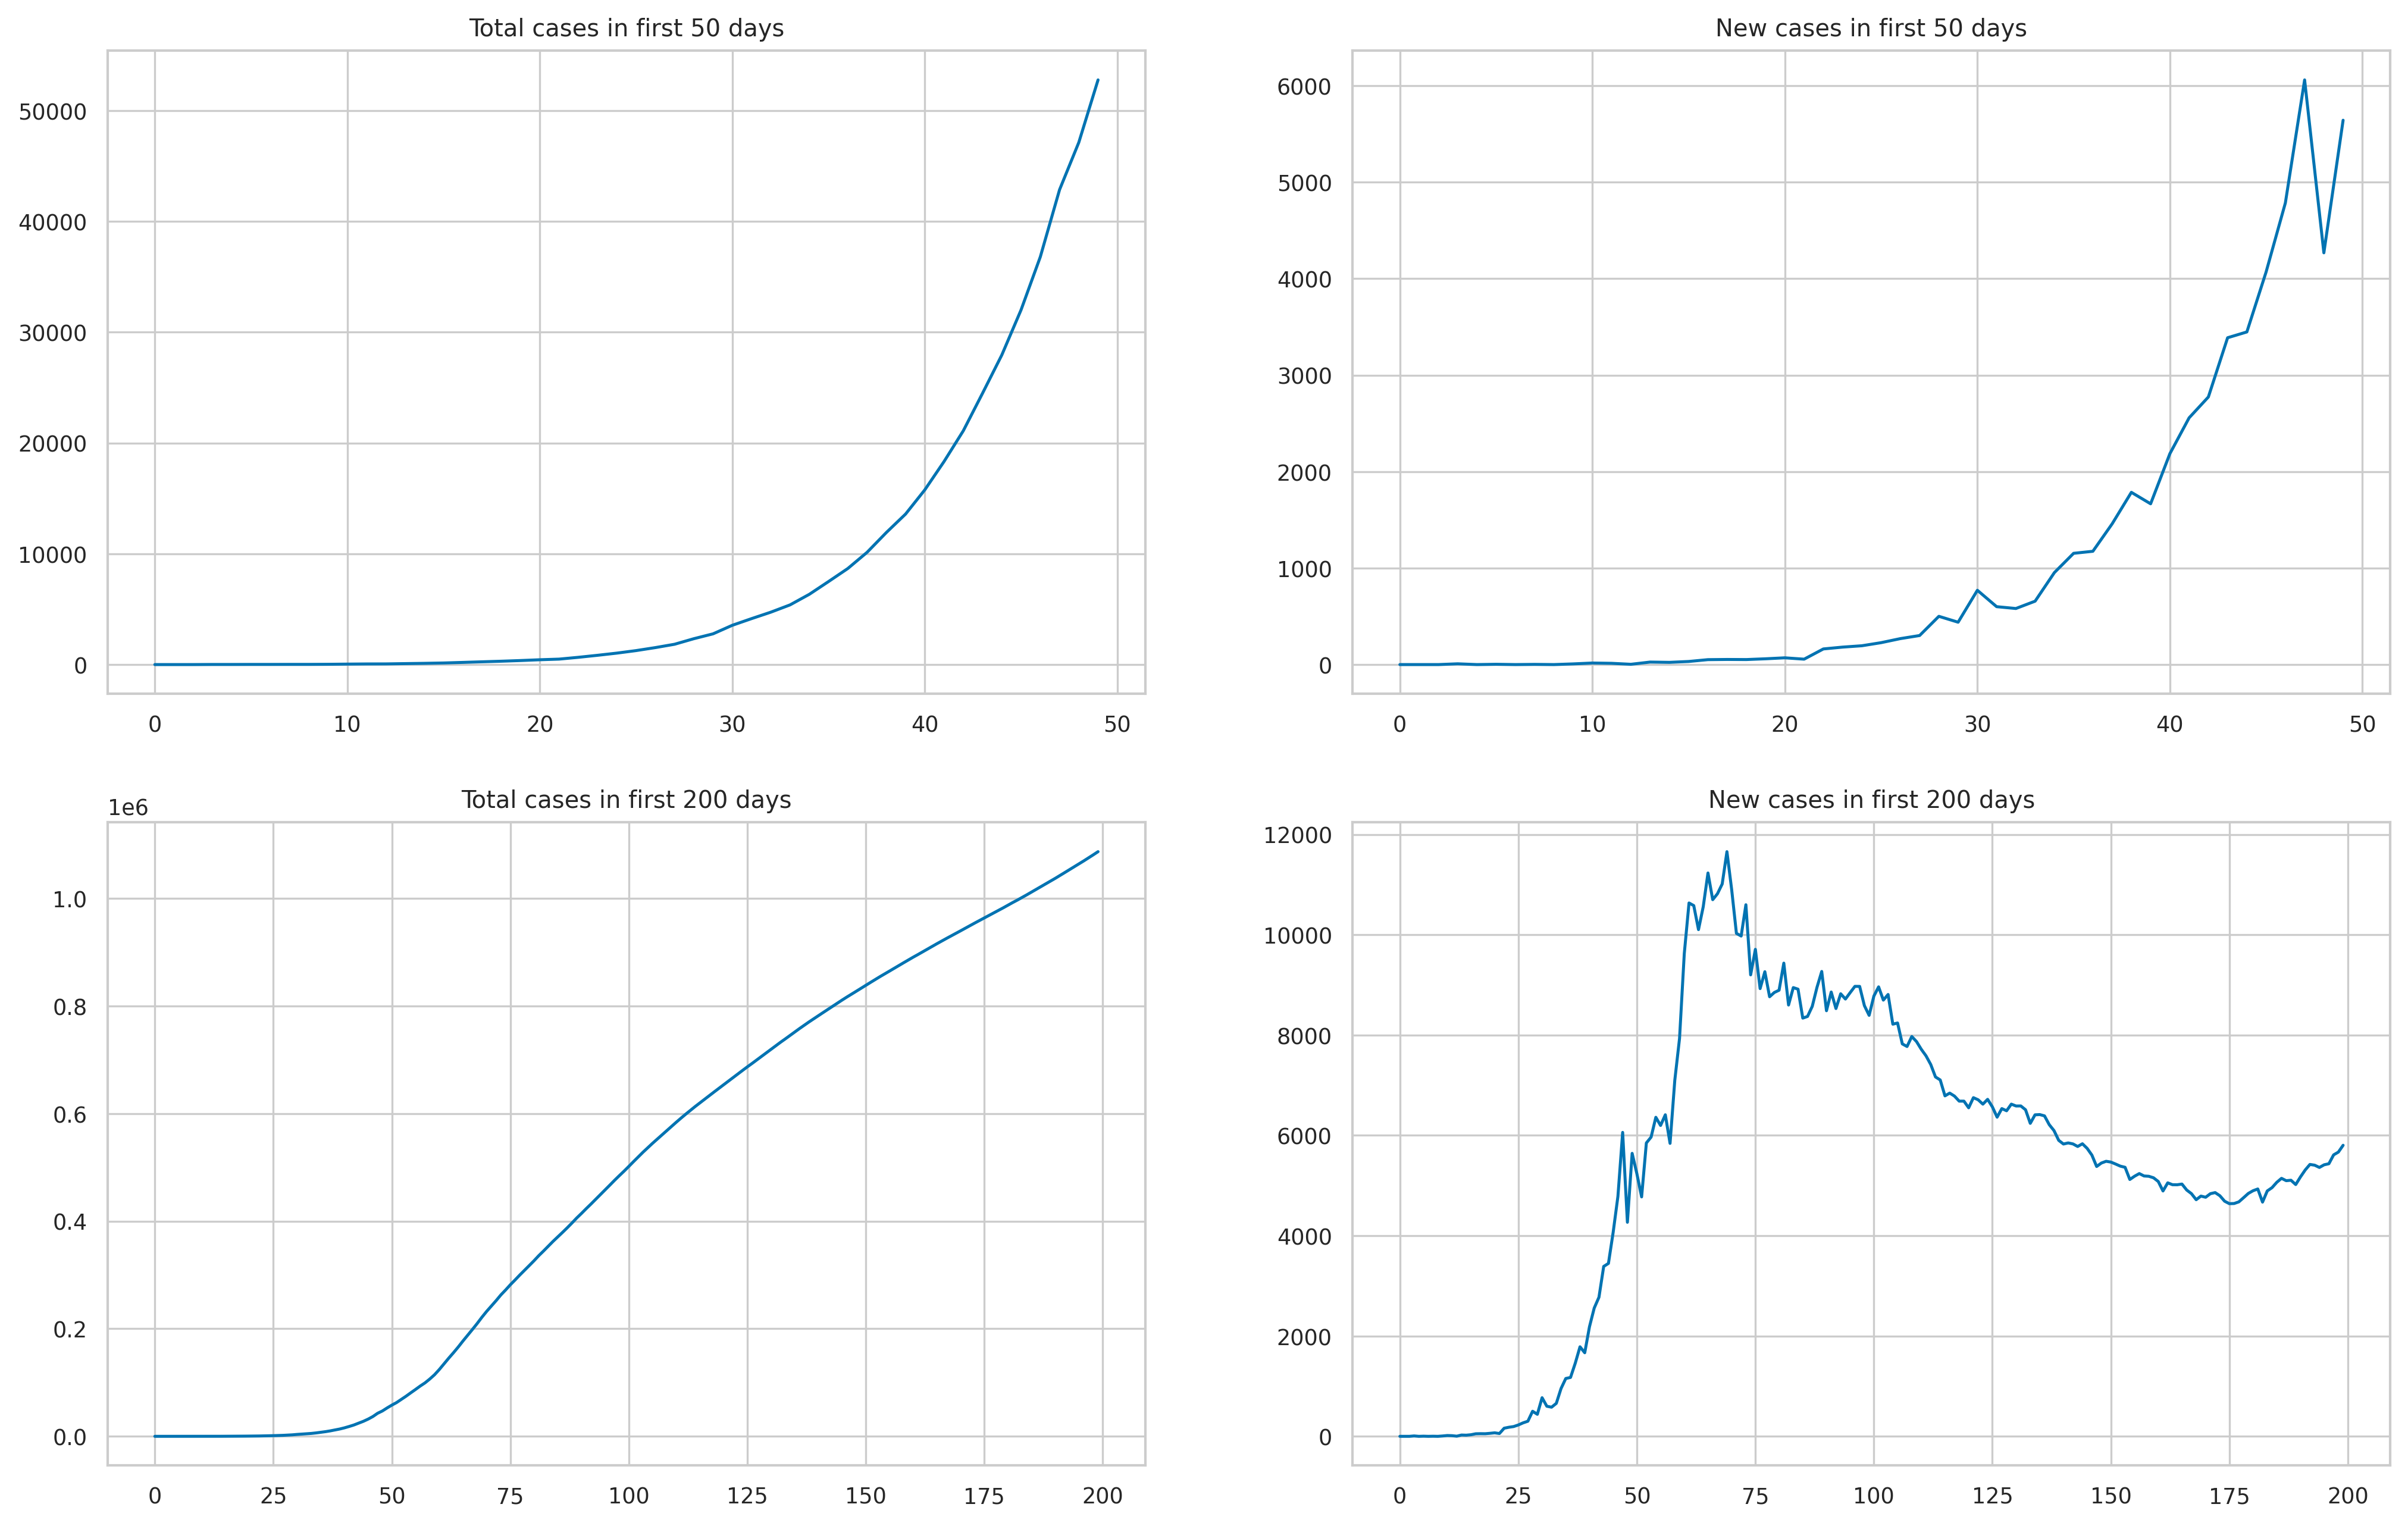

In [ ]:
fig = plt.figure(figsize=figsize)
spec = fig.add_gridspec(ncols=2, nrows=2)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(train['total_cases'])
ax0.set_title("Total cases in first 50 days")

ax1 = fig.add_subplot(spec[0, 1])
ax1.plot(train['new_cases'])
ax1.set_title("New cases in first 50 days")

ax2 = fig.add_subplot(spec[1, 0])
ax2.plot(df['total_cases'][:200])
ax2.set_title("Total cases in first 200 days")

ax3 = fig.add_subplot(spec[1, 1])
ax3.plot(df['new_cases'][:200])
ax3.set_title("New cases in first 200 days")

fig.show()

#### Task 2.a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

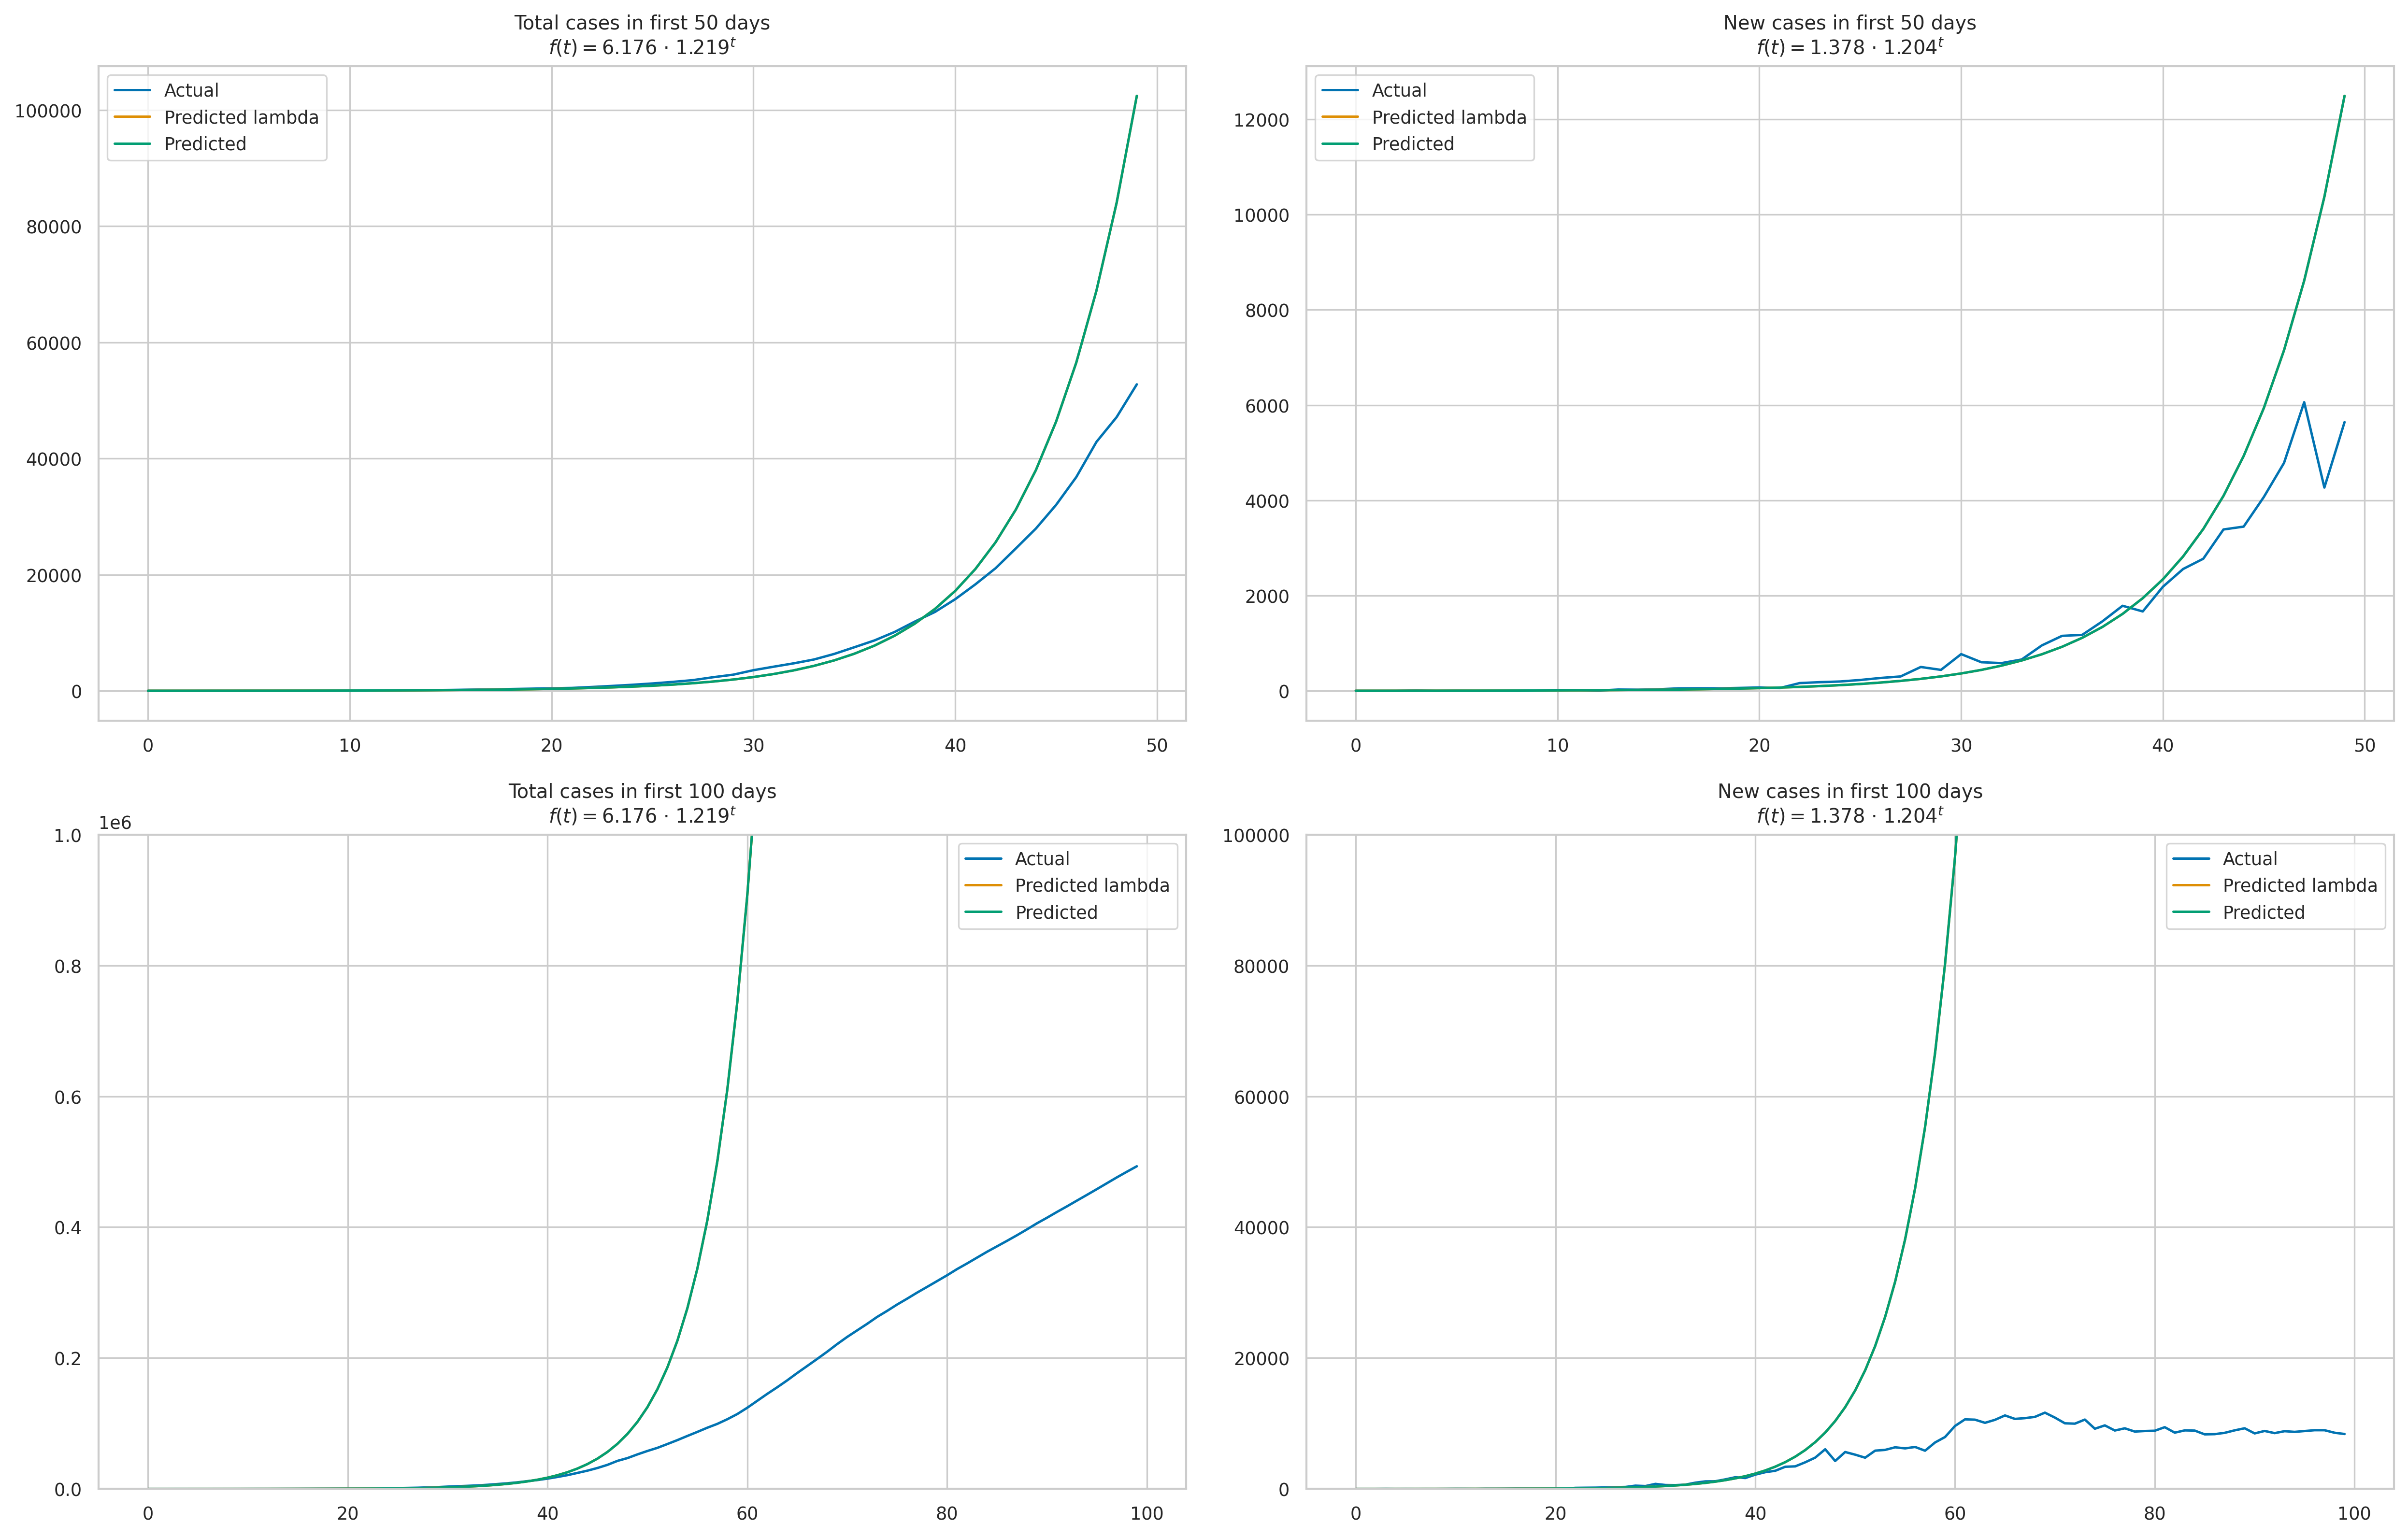

In [ ]:
def get_model(X,Y):
  Y_log = np.log(Y)

  lr = LinearRegression()
  res = lr.fit(X.reshape(-1,1), Y_log)
  f = lambda x : np.exp(res.intercept_ + res.coef_[0] * x)
  return res, f    

# total cases
X_train = np.array(train.index)
Y_train = np.array(train['total_cases'])
res_total, f_total = get_model(X_train, Y_train)

total_50 = res_total.predict(np.array(range(50)).reshape(-1,1))
total_100 = res_total.predict(np.array(range(100)).reshape(-1,1))

# new cases
Y_train = np.array(train['new_cases'])
res_new, f_new = get_model(X_train, Y_train)

new_50 = res_new.predict(np.array(range(50)).reshape(-1,1))
new_100 = res_new.predict(np.array(range(100)).reshape(-1,1))

# plot
x0_total = np.round(np.exp(res_total.intercept_), 3)
x0_new = np.round(np.exp(res_new.intercept_), 3)
b_total = np.round(np.exp(res_total.coef_[0]), 3)
b_new = np.round(np.exp(res_new.coef_[0]), 3)

fig = plt.figure(figsize=figsize, constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(train['total_cases'], label="Actual")
ax0.plot(np.array([f_total(i) for i in range(50)]), label="Predicted lambda")
ax0.plot(np.exp(total_50), label="Predicted")
ax0.set_title("Total cases in first 50 days\n" r"$f(t)= ${0} $\cdot$ {1}$^{{t}}$".format(x0_total, b_total))
ax0.legend()

ax1 = fig.add_subplot(spec[0, 1])
ax1.plot(train['new_cases'], label="Actual")
ax1.plot(np.array([f_new(i) for i in range(50)]), label="Predicted lambda")
ax1.plot(np.exp(new_50), label="Predicted")
ax1.set_title("New cases in first 50 days\n" r"$f(t)= ${0} $\cdot$ {1}$^{{t}}$".format(x0_new, b_new))
ax1.legend()

ax2 = fig.add_subplot(spec[1, 0])
ax2.plot(df['total_cases'][:100], label="Actual")
ax2.plot(np.array([f_total(i) for i in range(100)]), label="Predicted lambda")
ax2.plot(np.exp(total_100), label="Predicted")
ax2.set_title("Total cases in first 100 days\n" r"$f(t)= ${0} $\cdot$ {1}$^{{t}}$".format(x0_total, b_total))
ax2.set_ylim(bottom = 0, top = 1000000)
ax2.legend()

ax3 = fig.add_subplot(spec[1, 1])
ax3.plot(df['new_cases'][:100], label="Actual")
ax3.plot(np.array([f_new(i) for i in range(100)]), label="Predicted lambda")
ax3.plot(np.exp(new_100), label="Predicted")
ax3.set_title("New cases in first 100 days\n" r"$f(t)= ${0} $\cdot$ {1}$^{{t}}$".format(x0_new, b_new))
ax3.set_ylim(bottom = 0, top = 100000)
ax3.legend()

fig.show()

#### Task 2.b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [ ]:
X = sm.add_constant(X_train)
mu0 = np.zeros(X.shape[1])
sigma0 = 100 * np.eye(X.shape[1])
Y_new = np.log(np.array(train['new_cases']))
Y_total = np.log(np.array(train['total_cases']))
var_new = np.var(Y_new - new_50)
var_total = np.var(Y_total - total_50)

In [ ]:
def plot_heatmap(cur_mu, cur_sigma, xmin, xmax, ymin, ymax, N = 300):
    
    X_ = np.linspace(xmin, xmax, N)
    Y_ = np.linspace(ymin, ymax, N)
    X_, Y_ = np.meshgrid(X_, Y_)

    pos = np.empty(X_.shape + (2,))
    pos[:, :, 0] = X_
    pos[:, :, 1] = Y_
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    print(Z.shape)
    plt.figure(figsize = (5, 5), dpi = 100)
    plt.title('Распределение параметров модели')
    plt.pcolormesh(X_, Y_, Z, cmap=plt.cm.jet)

(300, 300)


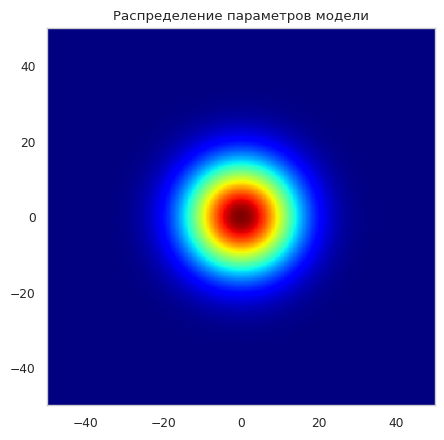

In [ ]:
plot_heatmap(mu0, sigma0, xmin = -50, xmax = 50, ymin = -50, ymax = 50)

In [ ]:
def bayesian_update(mu, sigma, x, y, var):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + 
                            (1 / var) * np.matmul(np.transpose(x), x))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + 
                     (1 / var) * np.matmul(np.transpose(x), np.array(y)))
    return mu_n, sigma_n

In [ ]:
cur_mu_total, cur_sigma_total = bayesian_update(mu0, sigma0, X, Y_total, var_total)
cur_mu_new, cur_sigma_new = bayesian_update(mu0, sigma0, X, Y_new, var_new)

In [ ]:
print(f'New cases sigma: \n{cur_sigma_new}\nNew cases mu: \n{cur_mu_new}\n',
      f'Total cases sigma: \n{cur_sigma_total}\nTotal cases mu: \n{cur_mu_total}', sep='')

New cases sigma: 
[[ 2.75810864e-02 -8.35790422e-04]
 [-8.35790422e-04  3.41163190e-05]]
New cases mu: 
[0.32060062 0.18596571]
Total cases sigma: 
[[ 9.45888140e-03 -2.86632761e-04]
 [-2.86632761e-04  1.16995814e-05]]
Total cases mu: 
[1.8205655  0.19829611]


(300, 300)


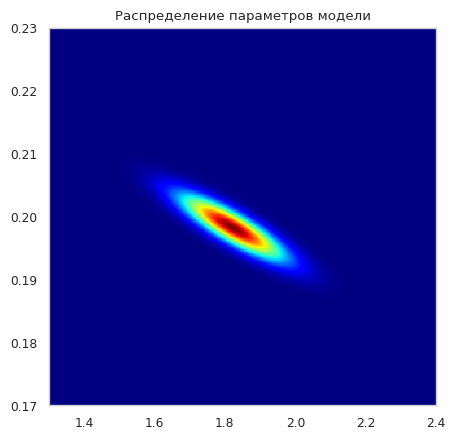

In [ ]:
plot_heatmap(cur_mu_total, cur_sigma_total, xmin = 1.3, xmax=2.4, ymin=0.17, ymax=0.23)

(300, 300)


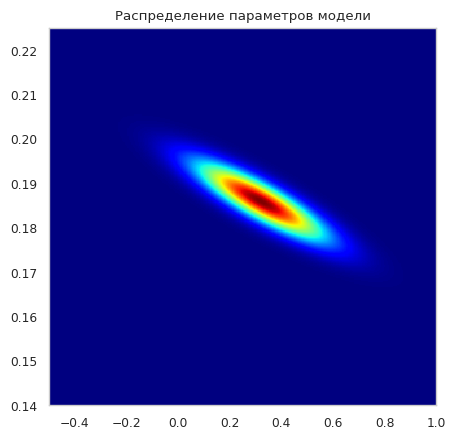

In [ ]:
plot_heatmap(cur_mu_new, cur_sigma_new, xmin = -0.5, xmax=1, ymin=0.14, ymax=0.225)

#### Task 2.c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [ ]:
def plot_samples(mu, sigma, column, N = 200):
  X_samples = range(len(np.append(train.index, test.index)))
  weights = np.random.multivariate_normal(mu, sigma, N) 
  
  ax = plt.subplot()

  for weight in weights:
    ax.plot(X_samples, np.exp(weight[0] + weight[1]*X_samples), 'r', linewidth=0.2)

  X_train = range(len(train)) 
  X_test = np.array(range(len(test))) + max(range(len(train))) + 1
  ax.plot(X_train, train[column], label='Train', linewidth=2)
  ax.plot(X_test, test[column], label='Test', linewidth=2)
  ax.set_title(column)
  ax.legend()
  ax.set_ylim(bottom = 0, top = max(test[column]) * 1.1)

  return ax, weights

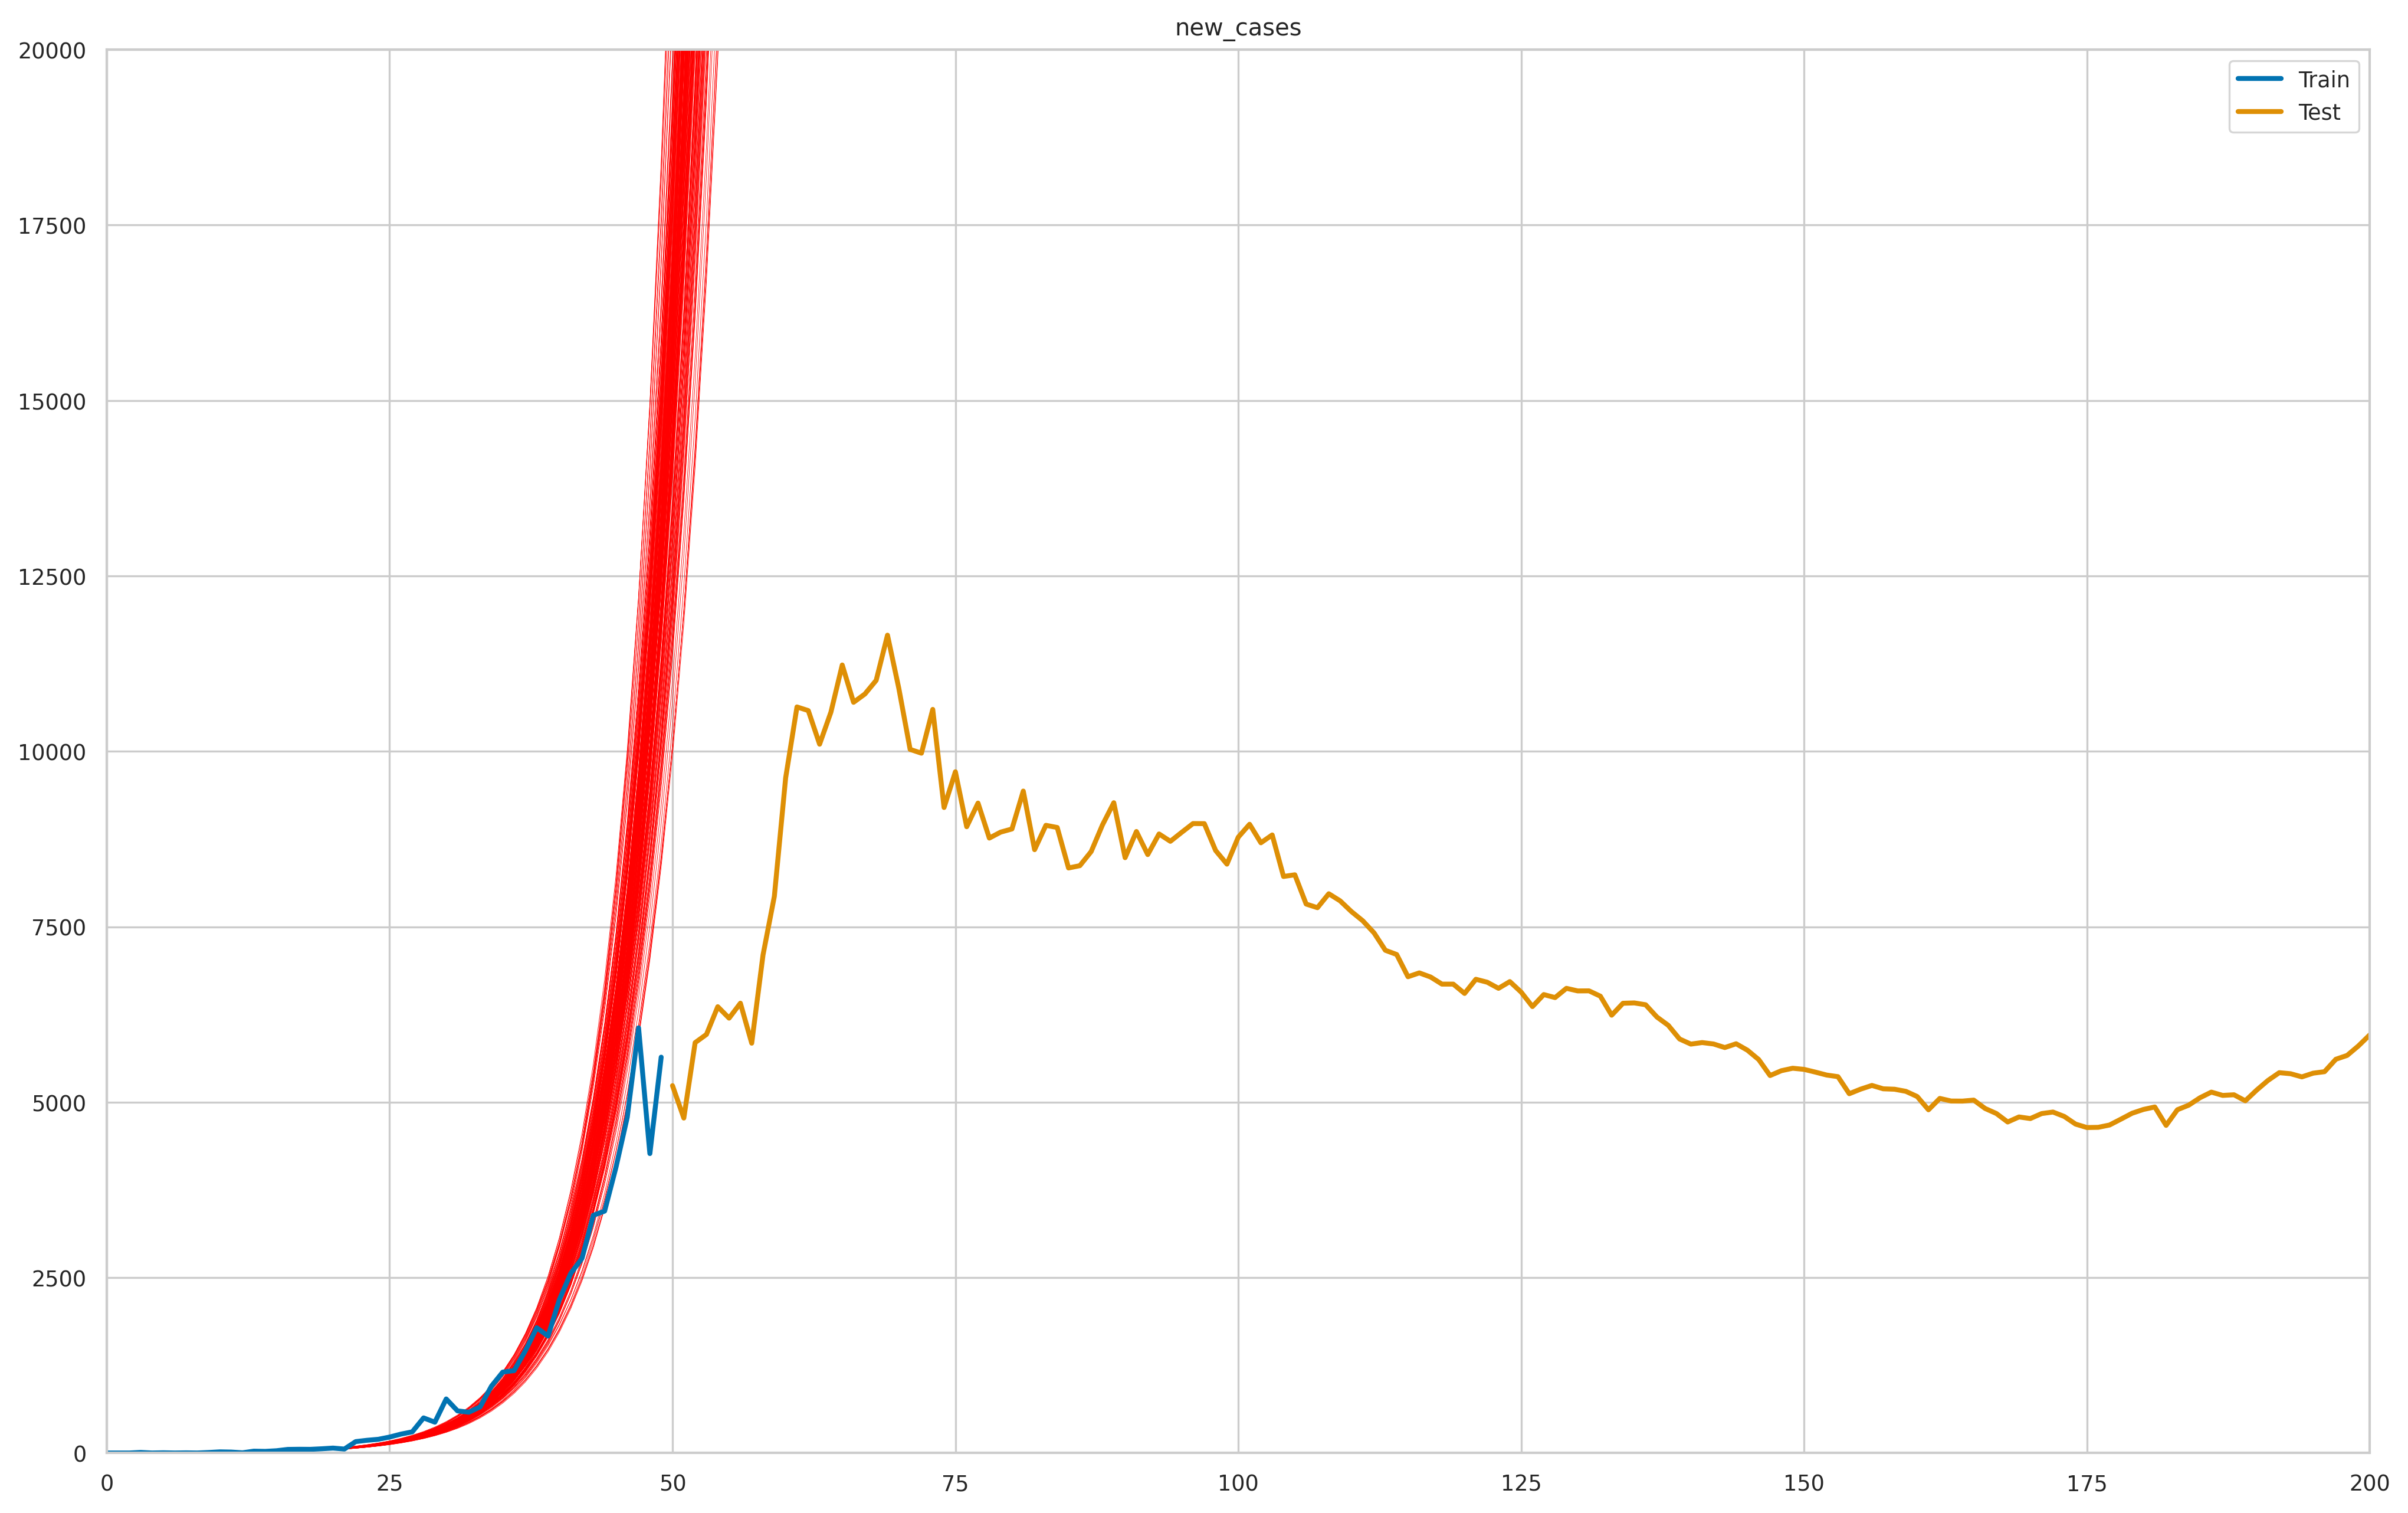

In [ ]:
fig = plt.figure(figsize=figsize)
axis_n, new_weights = plot_samples(cur_mu_new, cur_sigma_new, "new_cases")
ax1 = fig.add_subplot(axis_n)
ax1.set_ylim(bottom = 0, top = 2e4)
ax1.set_xlim(left = 0, right = 200)
fig.show()

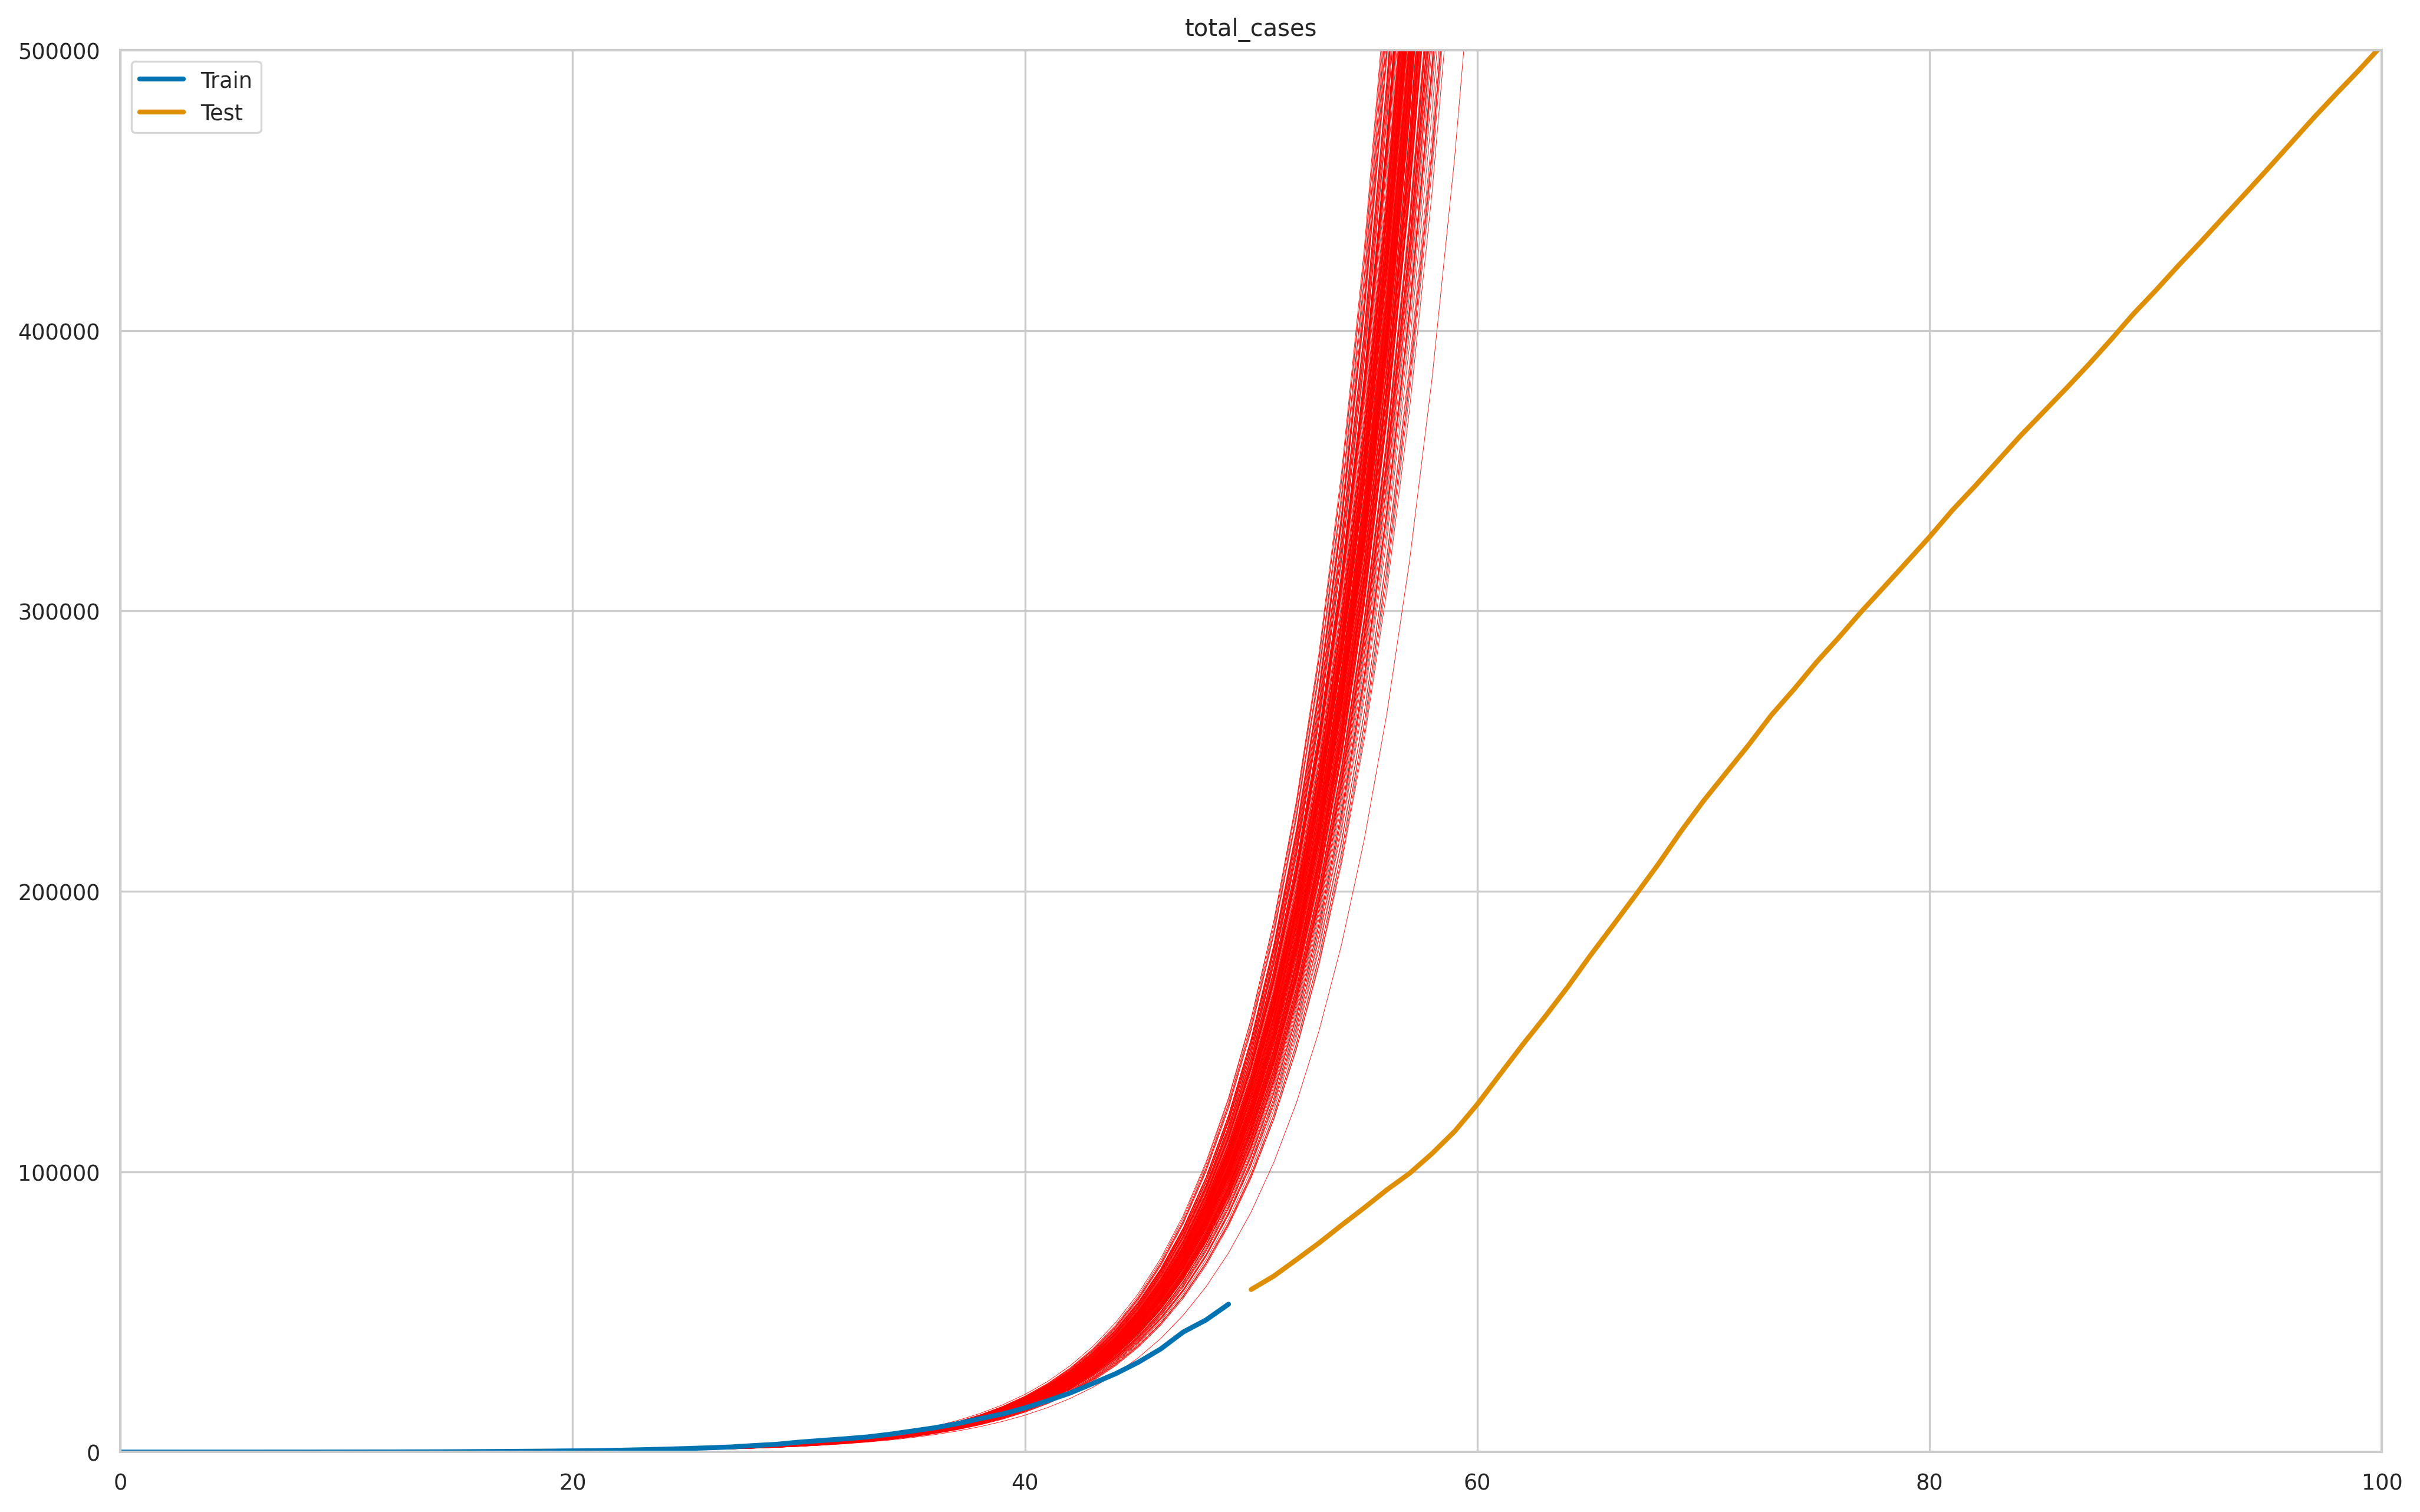

In [ ]:
fig = plt.figure(figsize=figsize)
axis_t, total_weights = plot_samples(cur_mu_total, cur_sigma_total, "total_cases")
ax1 = fig.add_subplot(axis_t)
ax1.set_ylim(bottom = 0, top = 5e5)
ax1.set_xlim(left = 0, right = 100)

fig.show()

In [ ]:
def get_predictions_for_date(date, weights):
  x = df[df['date'] == date].index[0]
  predictions = []
  for w in weights:
    pred = np.exp(w[0] + w[1]*x)
    predictions.append(pred)
  return np.array(predictions)

In [ ]:
dates = ['2020-05-01','2020-06-01','2020-09-01']
rc('figure', **{'dpi': 100})
def plot_displots_per_date(dates, weights):
  for date in dates:
    
    preds = get_predictions_for_date(date, weights)
    p_median = np.round(np.median(preds), 2)
    preds = preds[preds <= np.percentile(preds, 99)]
    
    sns.displot(preds, kde=True)
    plt.axvline(x=p_median)
    plt.title(f"Дата {date}\nМедиана {p_median}")
    plt.show()

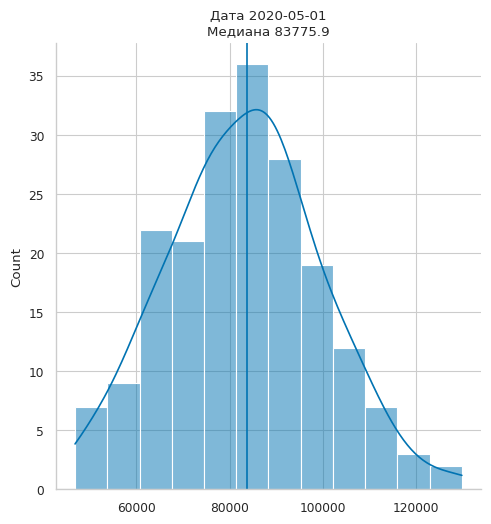

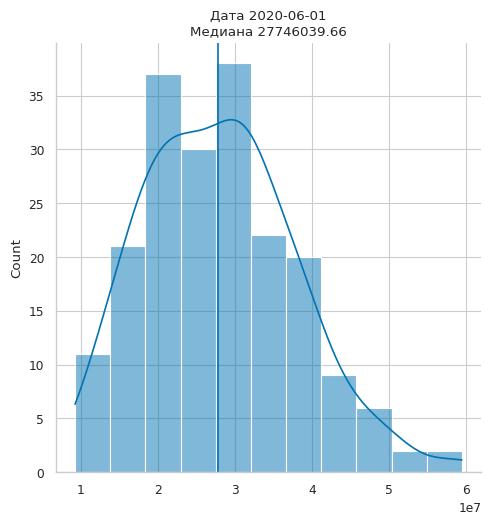

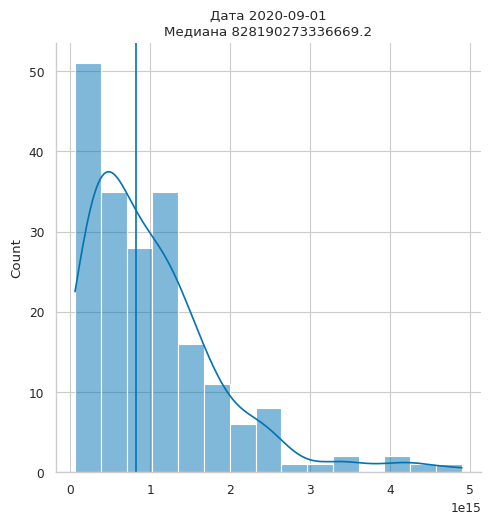

In [ ]:
plot_displots_per_date(dates, new_weights)

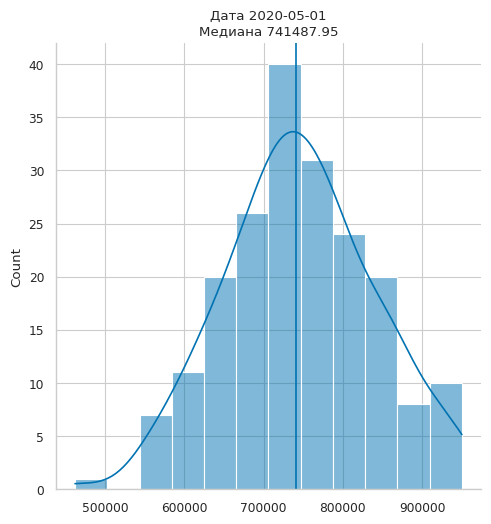

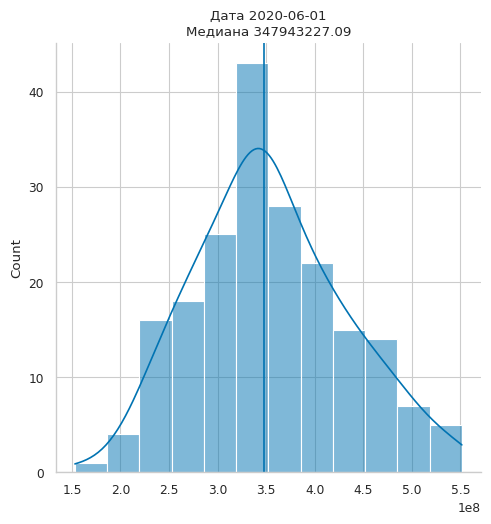

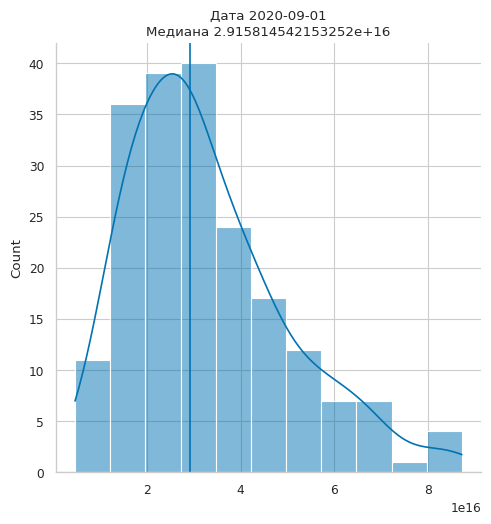

In [ ]:
plot_displots_per_date(dates, total_weights)

#### Task 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана.
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.



#### Task 3.a

a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Для описания новых случаев будем использовать квадратичную функцию. Для этого применим подход из первого задания. Значения общего количества зараженных будем получать из количества новых зараженных подсчетом комулятивной суммы.

#### Task 3.b

b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

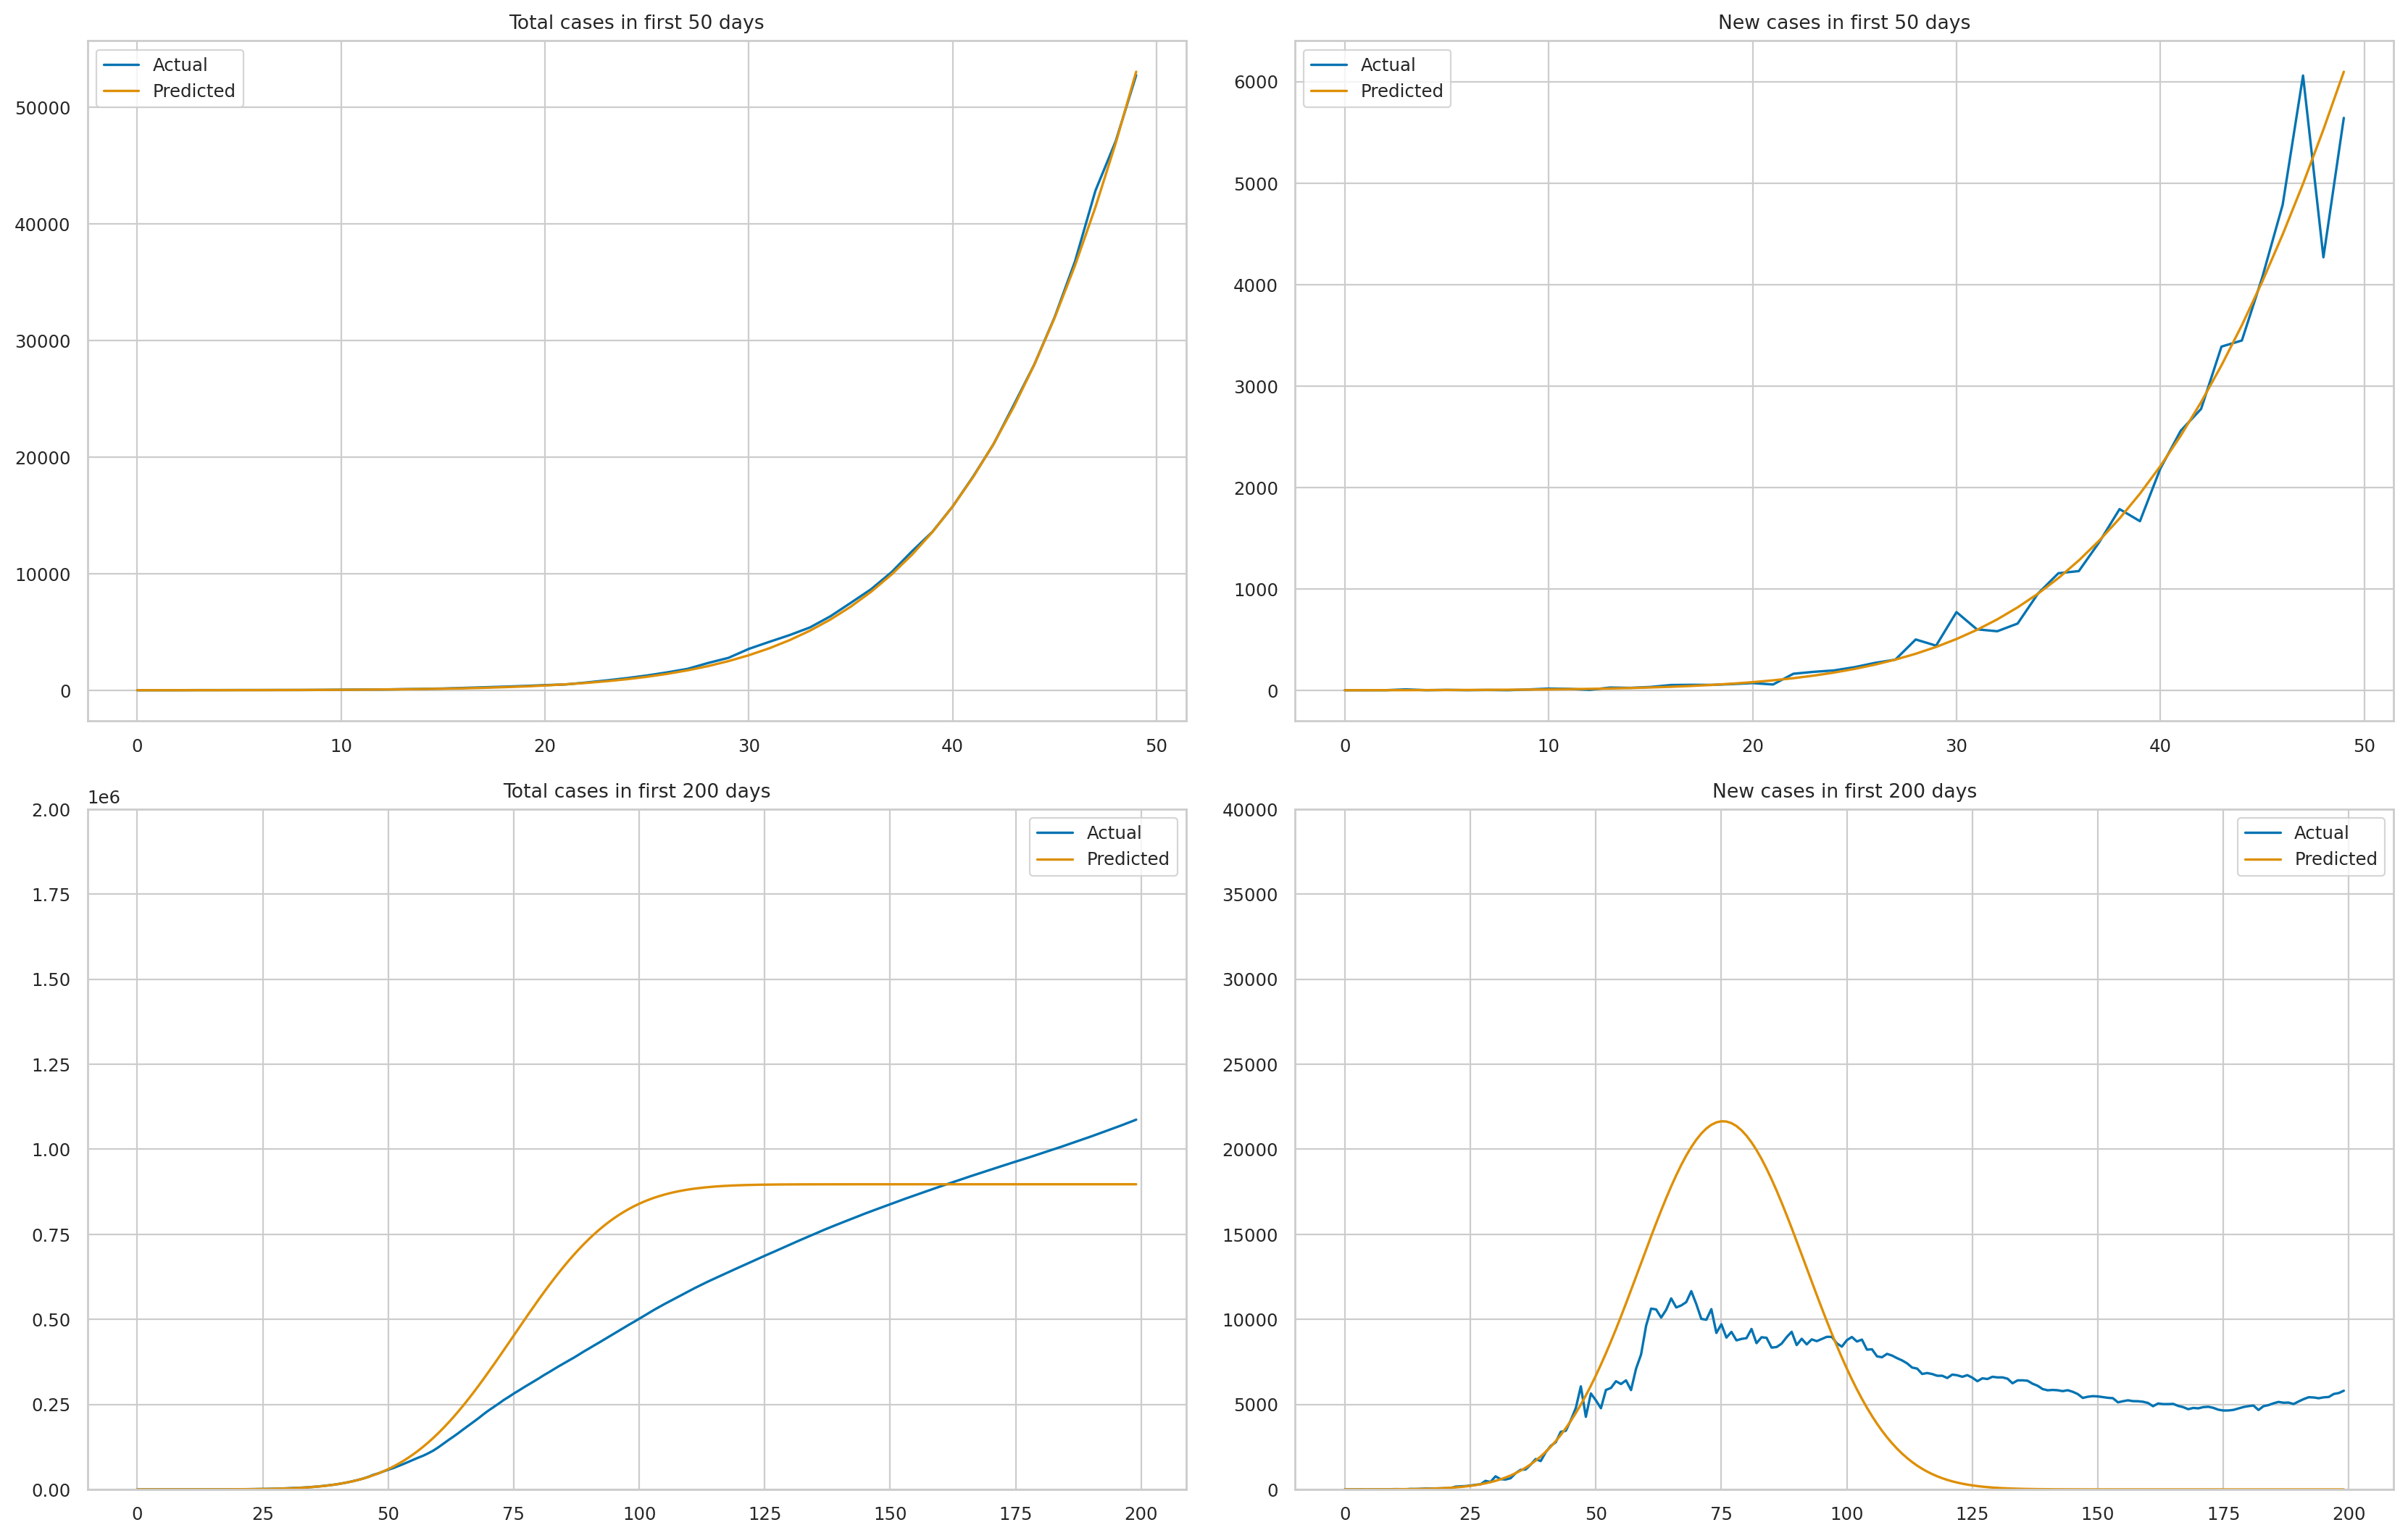

In [ ]:
def get_sigmoid_model(X,Y):
  
  X_ = np.array([X, X**2]).T  
  Y_log = np.log(Y)

  lr = LinearRegression()
  res = lr.fit(X_, Y_log)
  return res, X_, Y_log

X_train = np.array(train.index)
X_test = np.array(test.index) + TRAIN_DAYS

# new cases
Y_train = np.array(train['new_cases'])

Y_test = np.array(test['new_cases'])

_, x_test, y_test_new = get_sigmoid_model(X_test, Y_test)

res_new, x_train, y_train_new = get_sigmoid_model(X_train, Y_train)

x_full = np.vstack((x_train, x_test))

new_50 = np.exp(res_new.predict(x_full[:50]))
new_200 = np.exp(res_new.predict(x_full[:200]))

total_50 = np.cumsum(new_50)
total_200 = np.cumsum(new_200)

# plot
rc('figure', **{'dpi': 200})

fig = plt.figure(figsize=figsize, constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(train['total_cases'], label="Actual")
ax0.plot(total_50, label="Predicted")
ax0.set_title("Total cases in first 50 days")
ax0.legend()

ax1 = fig.add_subplot(spec[0, 1])
ax1.plot(train['new_cases'], label="Actual")
ax1.plot(new_50, label="Predicted")
ax1.set_title("New cases in first 50 days")
ax1.legend()

ax2 = fig.add_subplot(spec[1, 0])
ax2.plot(df['total_cases'][:200], label="Actual")
ax2.plot(total_200, label="Predicted")
ax2.set_title("Total cases in first 200 days")
ax2.set_ylim(bottom = 0, top = 2e6)
ax2.legend()

ax3 = fig.add_subplot(spec[1, 1])
ax3.plot(df['new_cases'][:200], label="Actual")
ax3.plot(new_200, label="Predicted")
ax3.set_title("New cases in first 200 days")
ax3.set_ylim(bottom = 0, top = 4e4)
ax3.legend()

fig.show()

In [ ]:
X = sm.add_constant(x_train)
mu0 = np.zeros(X.shape[1])
sigma0 = 100 * np.eye(X.shape[1])

var_new = np.var(y_train_new - res_new.predict(x_full[:50]))

cur_mu_new, cur_sigma_new = bayesian_update(mu0, sigma0, X, y_train_new, var_new)

print(f'New cases sigma: \n{cur_sigma_new}\nNew cases mu: \n{cur_mu_new}\n')

New cases sigma: 
[[ 3.97858000e-02 -3.21446447e-03  5.41155378e-05]
 [-3.21446447e-03  3.54467031e-04 -6.76539758e-06]
 [ 5.41155378e-05 -6.76539758e-06  1.38075588e-07]]
New cases mu: 
[-0.39642376  0.27560911 -0.00182956]



#### Task 3.c

c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [ ]:
def plot_samples_sigmoid(mu, sigma, N = 200):
  
  X_samples = x_full
  weights = []
  weights = np.random.multivariate_normal(mu, sigma, N) 
  
  predictions_new = []
  predictions_total = []

  for weight in weights:
    prediction = np.exp(weight[0] + weight[1] * x_full[:,0] + weight[2] * x_full[:,1])
    predictions_new.append(prediction)
    predictions_total.append(np.cumsum(prediction))

  fig = plt.figure(figsize=figsize, constrained_layout=True)
  spec = fig.add_gridspec(ncols=2, nrows=1)

  column = "new_cases"

  ax0 = fig.add_subplot(spec[0, 0])

  for pred in predictions_new:
    ax0.plot(X_samples[:,0], pred, 'r', linewidth=0.1)

  X_train = range(len(train)) 
  X_test = np.array(range(len(test))) + max(range(len(train))) + 1
  ax0.plot(X_train, train[column], label='Train', linewidth=2)
  ax0.plot(X_test, test[column], label='Test', linewidth=2)
  ax0.set_title(column)
  ax0.legend()
  
  ax0.set_ylim(bottom = 0, top = 2e4)
  ax0.set_xlim(left = 0, right = 200)

  column = "total_cases"

  ax1 = fig.add_subplot(spec[0, 1])

  for pred in predictions_total:
    ax1.plot(X_samples[:,0], pred, 'r', linewidth=0.1)

  X_train = range(len(train)) 
  X_test = np.array(range(len(test))) + max(range(len(train))) + 1
  ax1.plot(X_train, train[column], label='Train', linewidth=2)
  ax1.plot(X_test, test[column], label='Test', linewidth=2)
  ax1.set_title(column)
  ax1.legend()
  
  ax1.set_ylim(bottom = 0, top = 1.5e6)
  ax1.set_xlim(left = 0, right = 200)

  fig.show()
  return weights, predictions_new

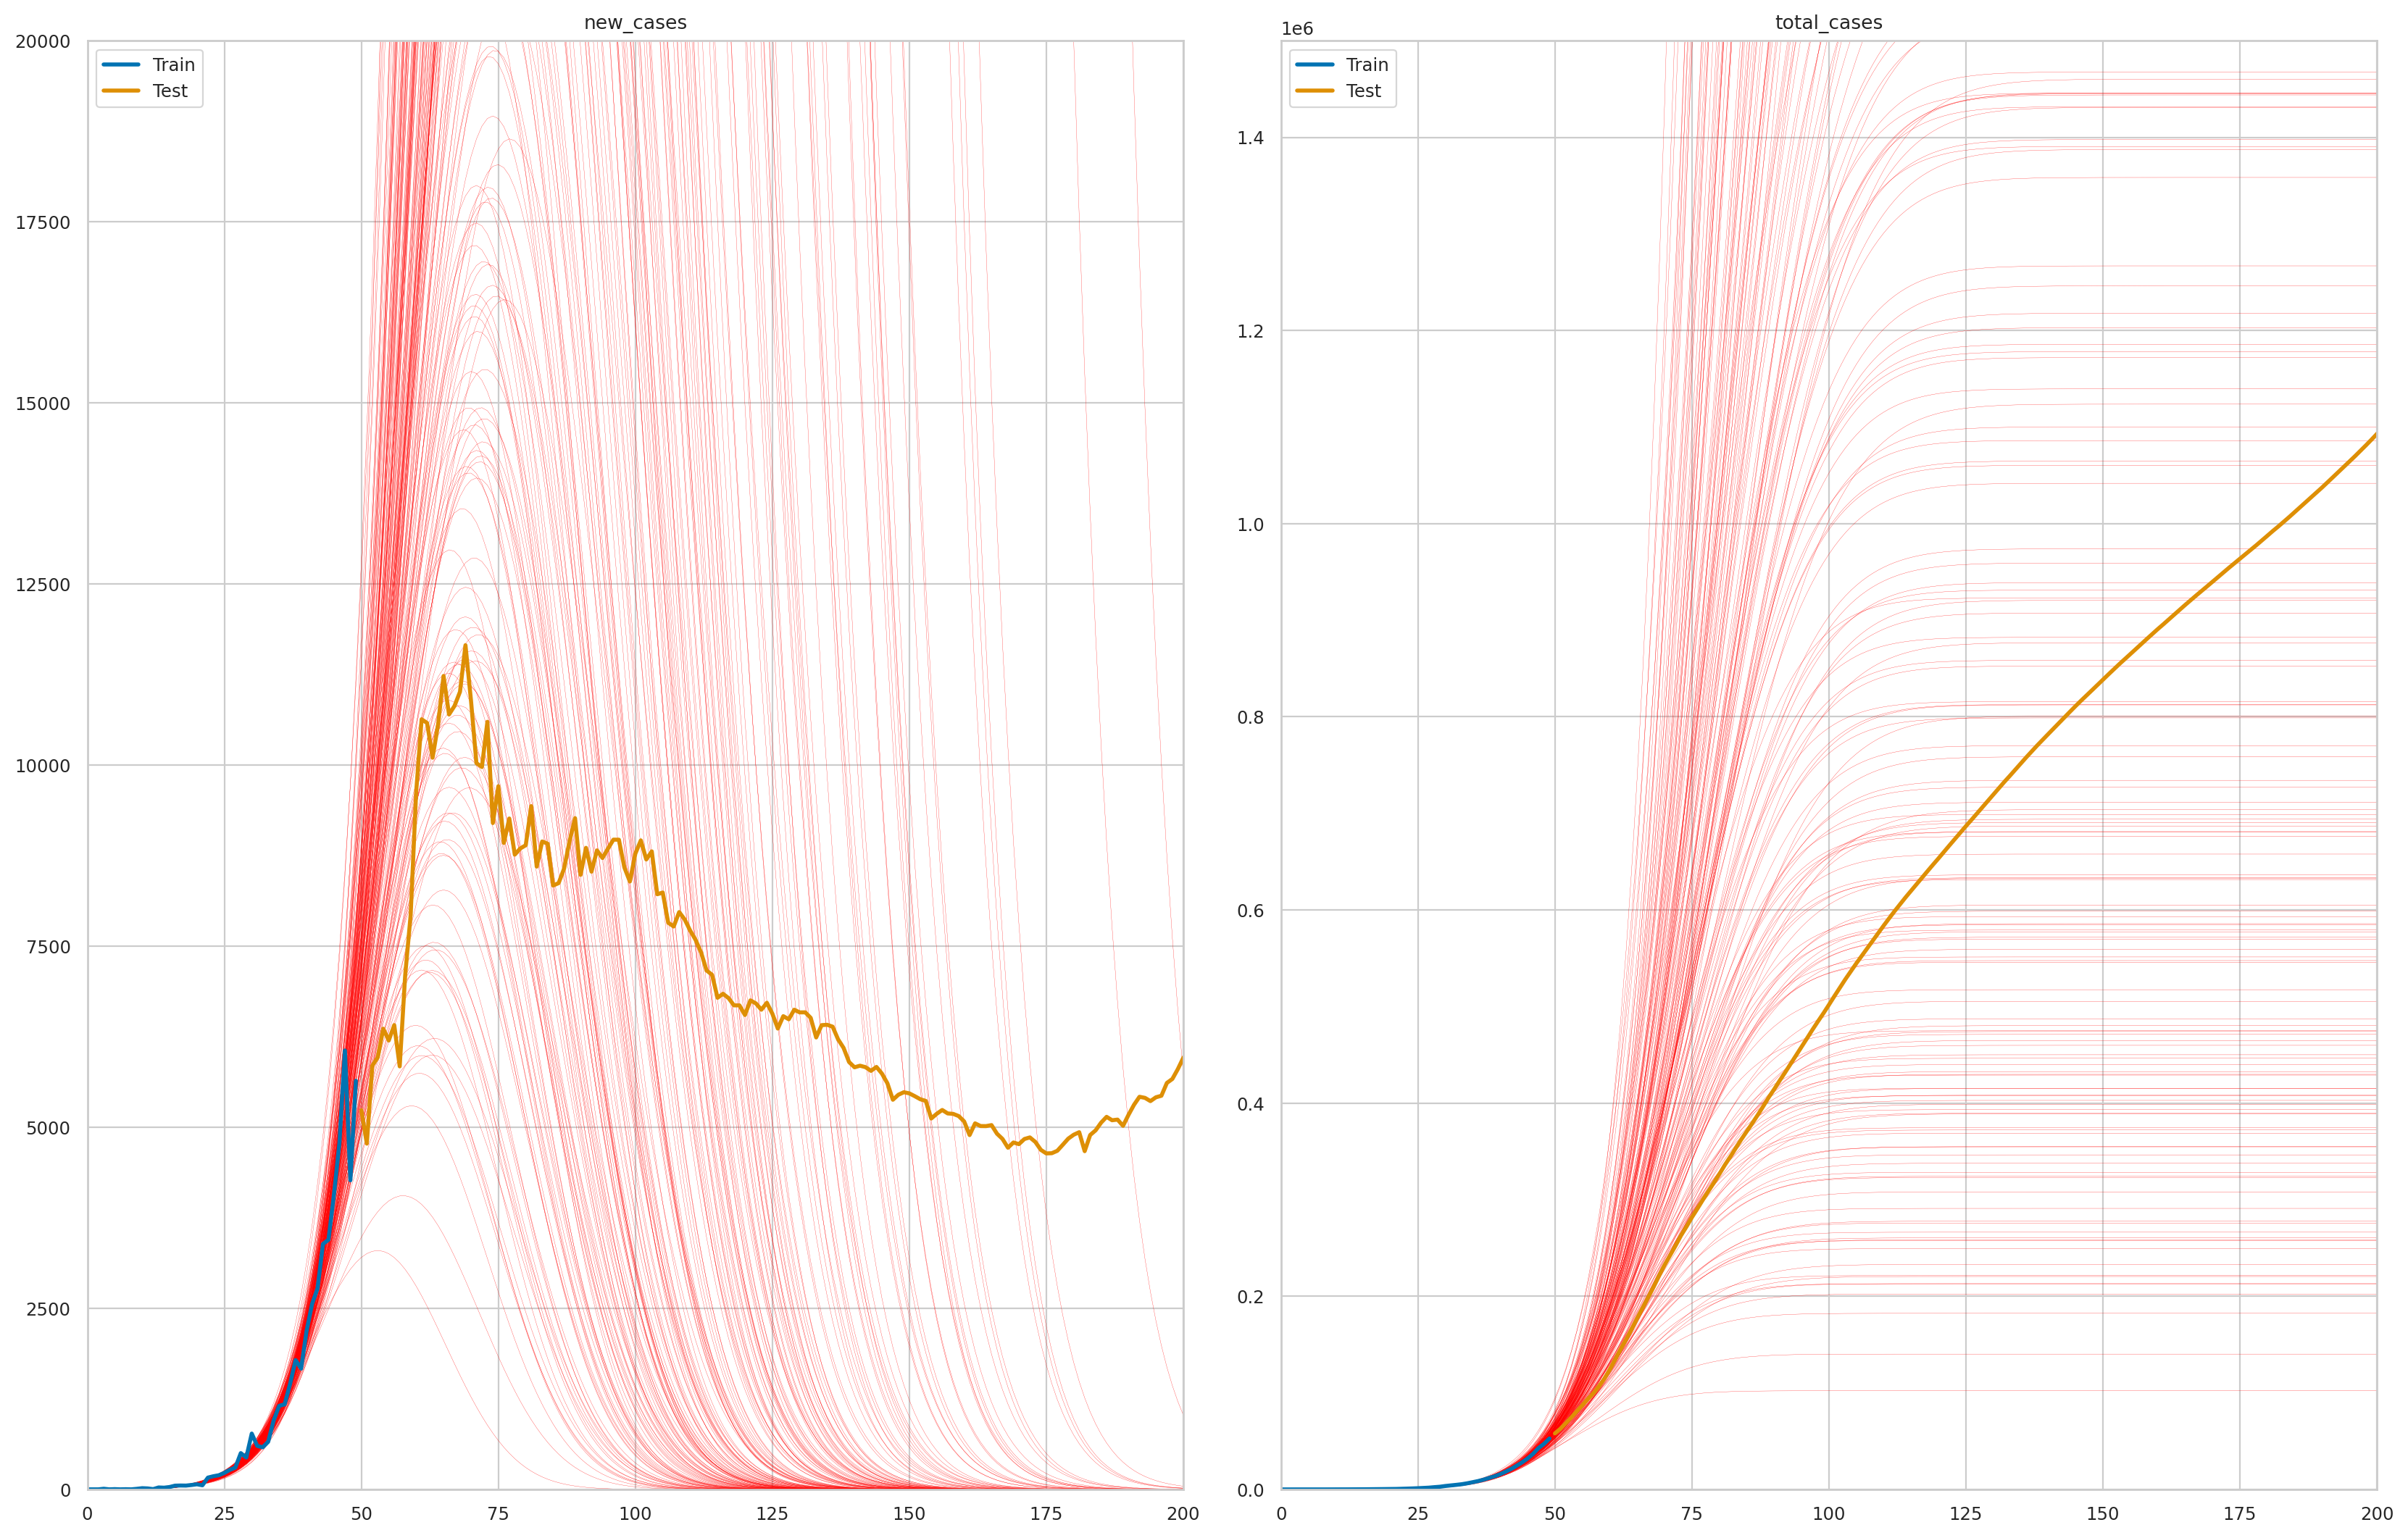

In [ ]:
weight_new_sigma = []
preds = []
weight_new_sigma, preds = plot_samples_sigmoid(cur_mu_new, cur_sigma_new)

Количество случаев при пессимистичном сценарии 7007672.660182821
Количество случаев при оптимистичном сценарии 327991.89577952237



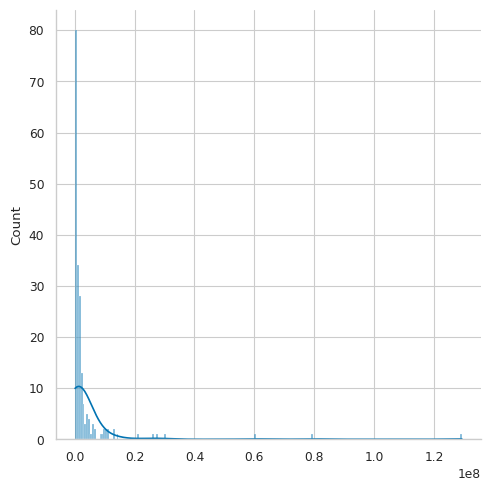

In [ ]:
total_samples = np.array(preds).cumsum(axis=1)[:, -1]

print(f"Количество случаев при пессимистичном сценарии {np.percentile(total_samples, 90)}\n",
      f"Количество случаев при оптимистичном сценарии {np.percentile(total_samples, 10)}\n", sep="")
total_samples = total_samples[total_samples <= np.percentile(total_samples, 99)]

rc('figure', **{'dpi': 100})
sns.displot(total_samples, kde=True)
plt.show()